<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2020-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **Clustering con distintas estrategias**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **Aplicación de reducción de dimensionalidad**: PCA y UMAP.
 - **Aplicación**: segmentación de imágenes de satélite.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nombre y apellidos: </strong>
</div>

Francisco Javier Melchor González

---

Para ello vamos a necesitar las siguientes librerías:

In [3]:
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster                   # Algoritmos de clustering.
from sklearn import datasets                  # Crear datasets.
from sklearn import manifold                  # Algoritmos de reduccion de dimensionalidad.
from sklearn import decomposition             # Módulo de reducción de dimensionalidad.
from sklearn.utils import check_random_state  # Gestión de números aleatorios.

# Clustering jerárquico y dendrograma.
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors

# UMAP para reducción de dimensionalidad.
import umap

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Métodos de *clustering* (4 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [4]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

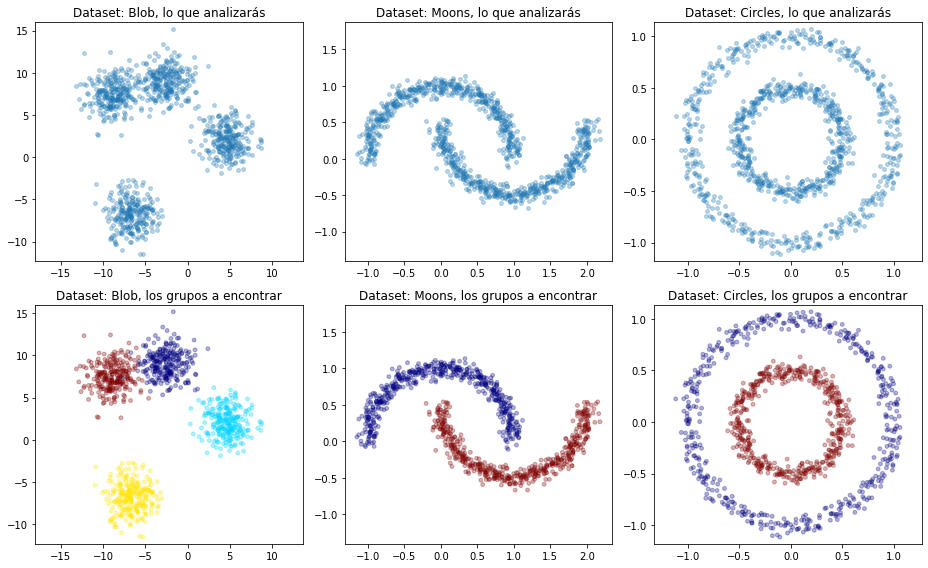

In [5]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [6]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

In [7]:
K = range(1, 10)
sse = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

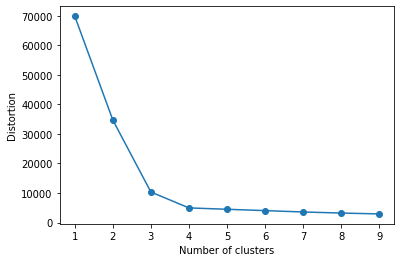

In [8]:
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

**En la gráfica mostrada anteriormente podemos ver que la distorsión**, que viene dada por el valor resultante del SSE, **va disminuyendo más rápidamente a partir del valor k = 3**, lo que quiere decir que **un valor de k mayor que 3 resultaría un ajuste excesivo en los datos**, y por lo tanto un número de grupos excesivamente grandes y que no se adecuaría a los datos, **siendo por tanto el valor 3 el adecuado dados los datos presentes en el dataset Blobs**

**La elección de k podría mejorarse aplicando el método de la silueta para los diferentes valores posibles de K y quedándonos con aquel cuya puntuación obtenida sea mayor**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

In [9]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


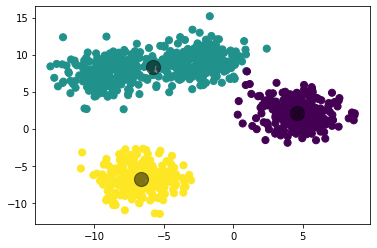

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En primer lugar lo que ha sucedido es que el valor óptimo de K obtenido según la regla del codo, es igual a 3 y realmente el número real de grupos en los datos es 4. Esto es debido a que los dos primeros grupos del dataset original se encuentran muy cercanos entre sí con respecto a la distancia existente entre los demás grupos, esto genera que la distorsión a partir de 3 grupos comience a disminuir notoriamente, porque ambos grupos originales al estar tan juntos, producen una distorsión muy similar al juntarse, y a simple vista, si no se sabe cuales son los grupos originales, parece que a partir del valor 3 se está ajustando demasiado el modelo.

Al elegir el valor 3 para la k, el algoritmo K-Means ha agrupado los dos primeros grupos en un mismo grupo y ha separado los demás grupos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

In [11]:
X, y = X_moons, y_moons

In [12]:
K = range(1, 10)
sse = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

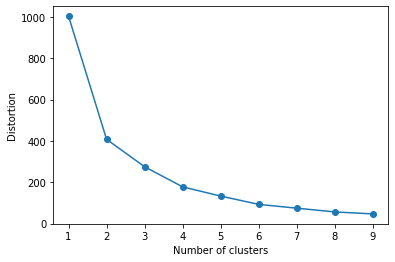

In [13]:
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

In [14]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


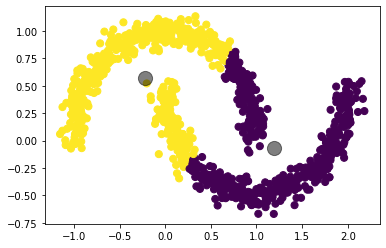

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

In [16]:
X, y = X_circles, y_circles

In [17]:
K = range(1, 10)
sse = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

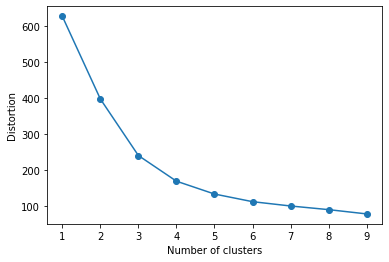

In [18]:
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

In [19]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


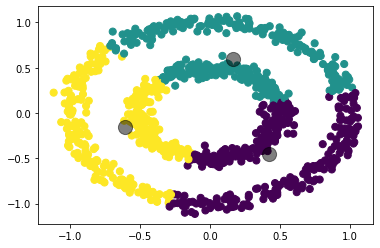

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### 1 b. Algoritmos basados en densidad: DBScan

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los grupos subyacentes.

In [21]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

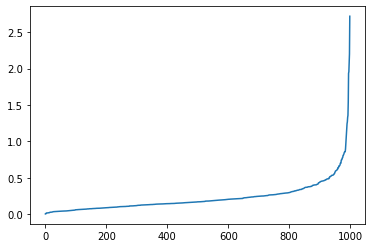

In [22]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [23]:
dbscan = cluster.DBSCAN(eps=0.6, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


In [24]:
def print_dbscan(labels):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

Estimated number of clusters: 30
Estimated number of noise points: 45


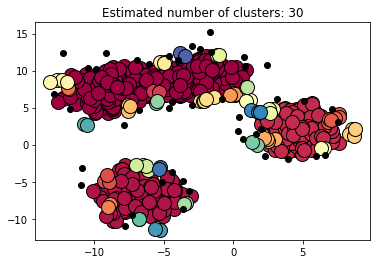

In [25]:
print_dbscan(labels)

In [26]:
dbscan = cluster.DBSCAN(eps=0.6, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

Estimated number of clusters: 9
Estimated number of noise points: 142


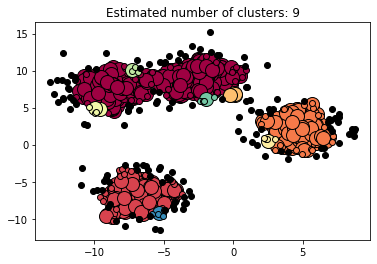

In [27]:
print_dbscan(labels)

In [28]:
dbscan = cluster.DBSCAN(eps=0.6, min_samples=10)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

Estimated number of clusters: 4
Estimated number of noise points: 316


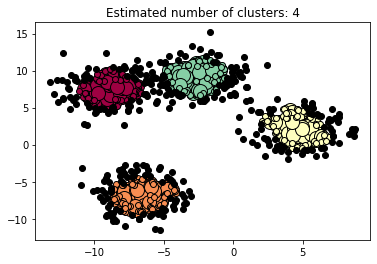

In [29]:
print_dbscan(labels)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

In [30]:
X, y = X_moons, y_moons

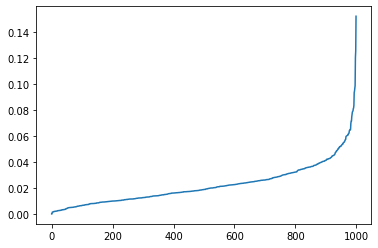

In [31]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [32]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 89
Estimated number of noise points: 115


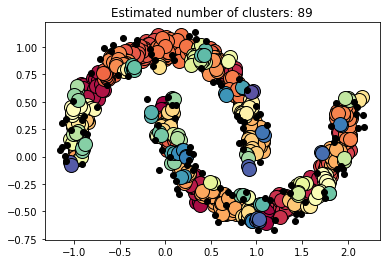

In [33]:
print_dbscan(labels)

In [34]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 48
Estimated number of noise points: 356


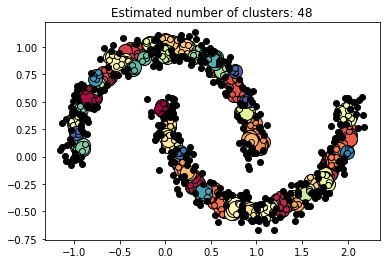

In [35]:
print_dbscan(labels)

In [36]:
dbscan = cluster.DBSCAN(eps=0.06, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 15
Estimated number of noise points: 33


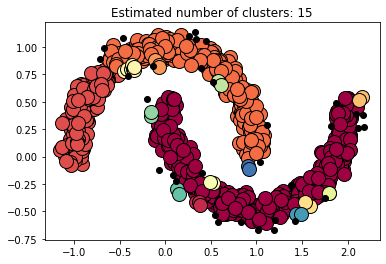

In [37]:
print_dbscan(labels)

In [38]:
dbscan = cluster.DBSCAN(eps=0.06, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 8
Estimated number of noise points: 78


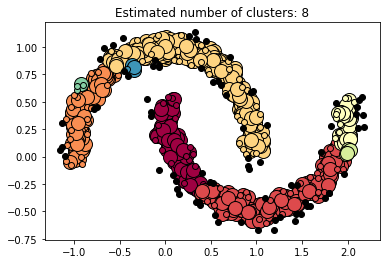

In [39]:
print_dbscan(labels)

In [40]:
dbscan = cluster.DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 2
Estimated number of noise points: 7


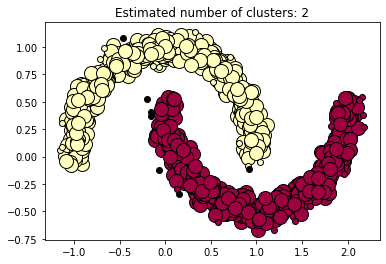

In [41]:
print_dbscan(labels)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

In [42]:
X, y = X_circles, y_circles

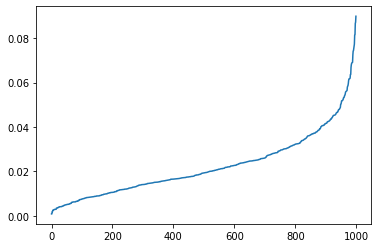

In [43]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [44]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 98
Estimated number of noise points: 116


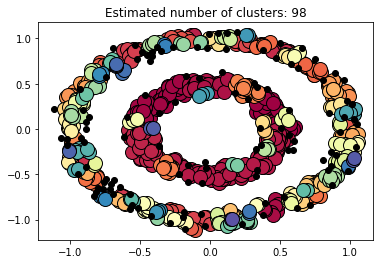

In [45]:
print_dbscan(labels)

In [46]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 41
Estimated number of noise points: 428


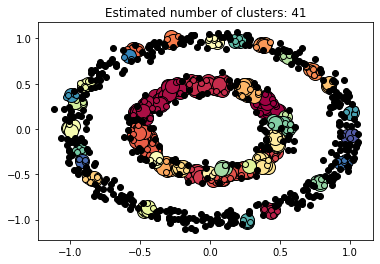

In [47]:
print_dbscan(labels)

In [48]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=10)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 10
Estimated number of noise points: 884


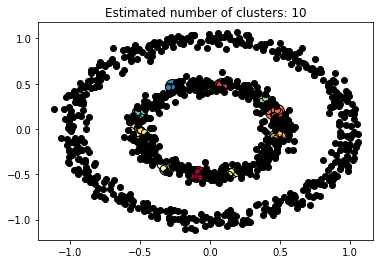

In [49]:
print_dbscan(labels)

In [50]:
dbscan = cluster.DBSCAN(eps=0.1, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 2
Estimated number of noise points: 0


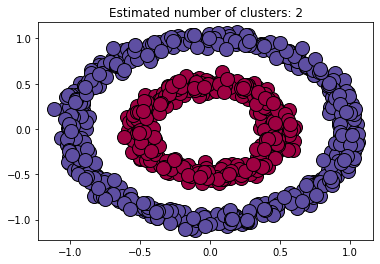

In [51]:
print_dbscan(labels)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [52]:
from sklearn.cluster import AgglomerativeClustering


In [53]:
def print_dendogram(linked):
    plt.figure(figsize=(10, 7))
    plt.title("Customer Dendograms")
    dend = dendrogram(linked, no_labels=True)

In [54]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong><br>

prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [55]:
linked = linkage(X, 'single')

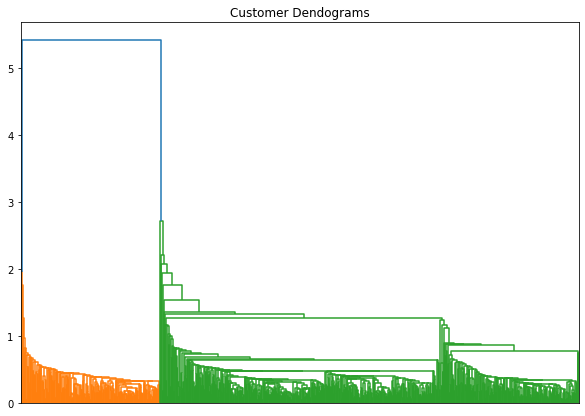

In [56]:
print_dendogram(linked)

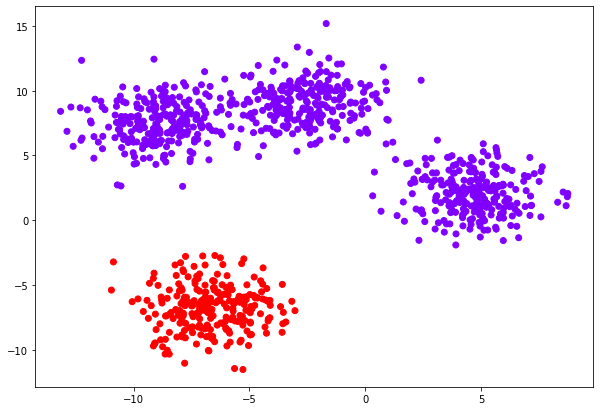

In [57]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='single')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [58]:
linked = linkage(X, 'complete')

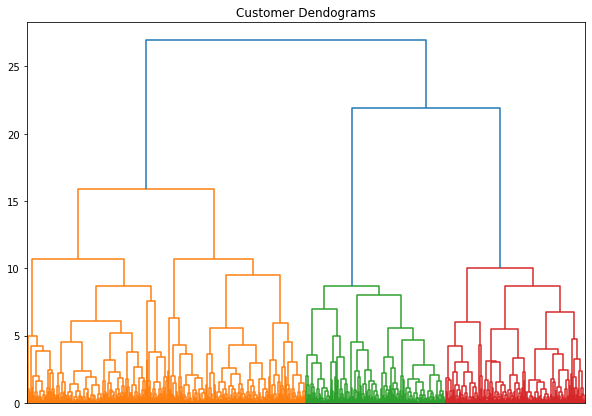

In [59]:
print_dendogram(linked)

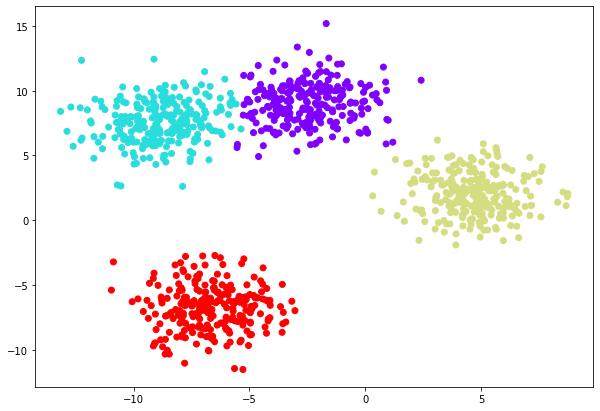

In [60]:

aglom_cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='complete')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [61]:
linked = linkage(X, 'average')

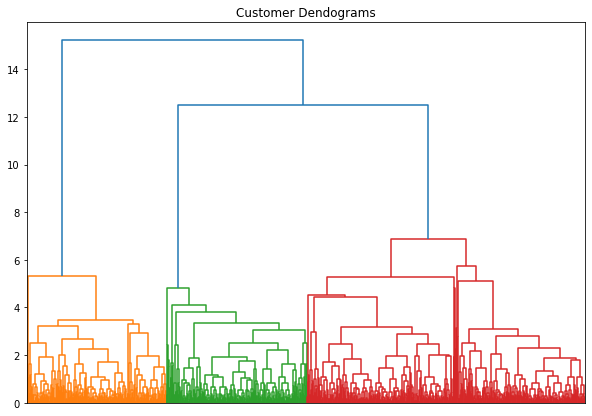

In [62]:
print_dendogram(linked)

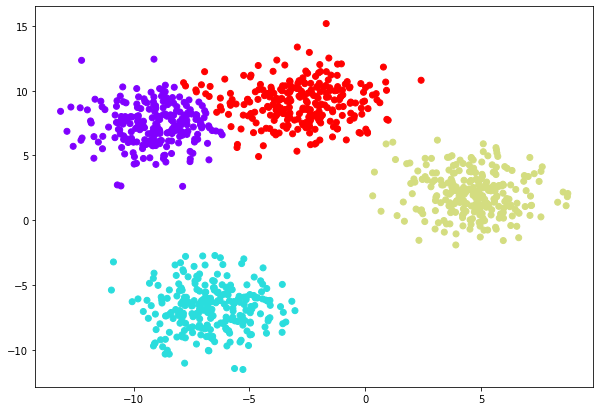

In [63]:

aglom_cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='average')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [64]:
linked = linkage(X, 'ward')

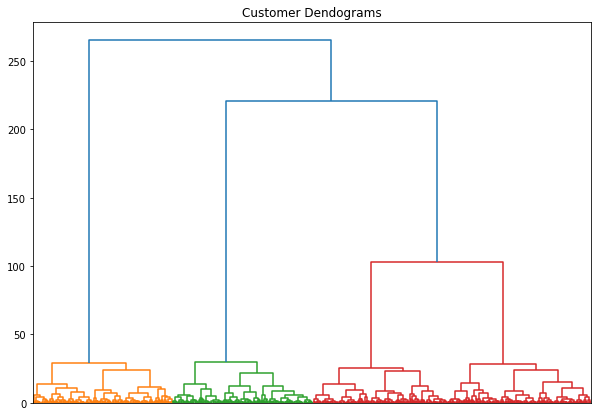

In [65]:
print_dendogram(linked)

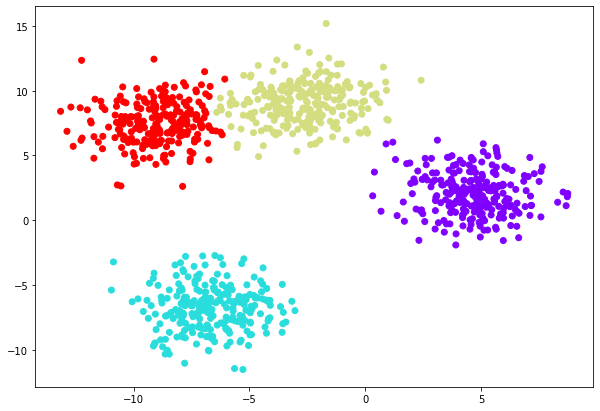

In [66]:

aglom_cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

## PENDIENTE DE JUSTIFICAR

ward y complete

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong><br>

prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [67]:
X, y = X_moons, y_moons

In [68]:
linked = linkage(X, 'single')

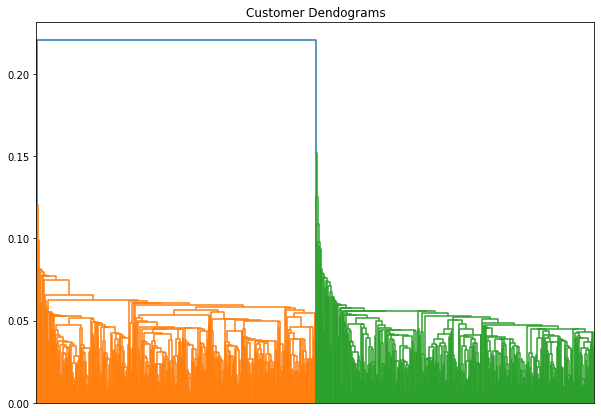

In [69]:
print_dendogram(linked)

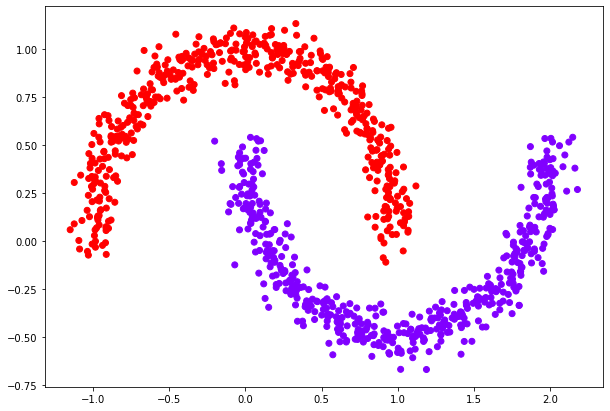

In [70]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='single')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [71]:
linked = linkage(X, 'complete')

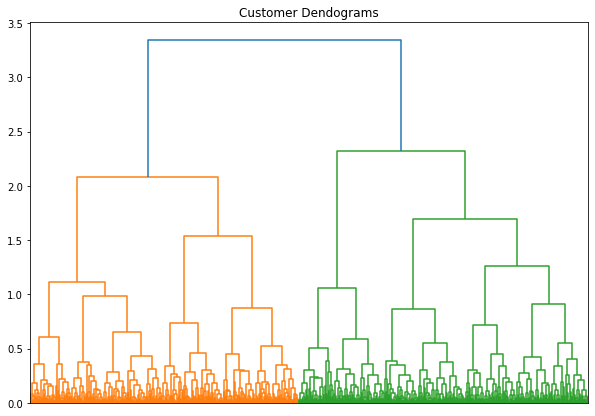

In [72]:
print_dendogram(linked)

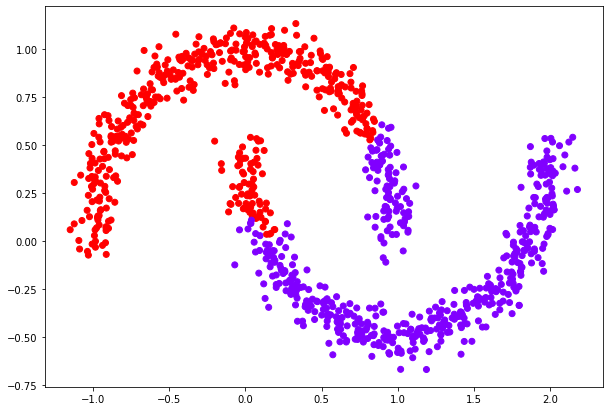

In [73]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='complete')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [74]:
linked = linkage(X, 'average')

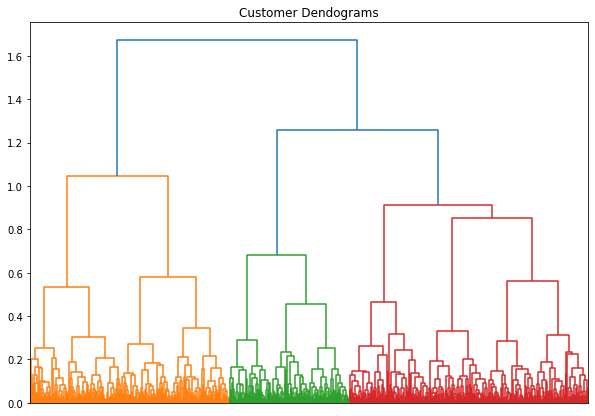

In [75]:
print_dendogram(linked)

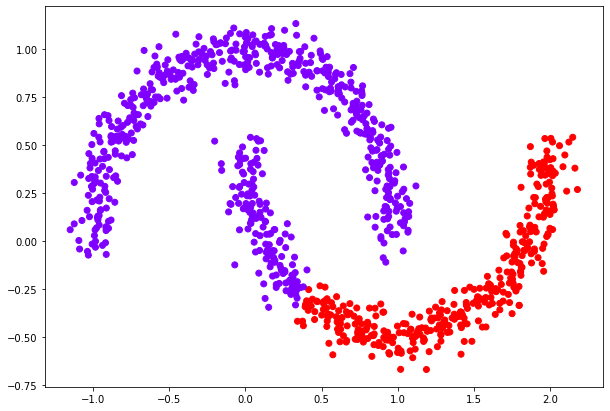

In [76]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='average')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [77]:
linked = linkage(X, 'ward')

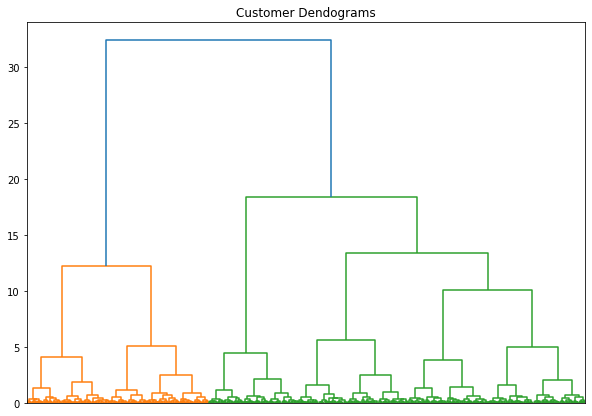

In [78]:
print_dendogram(linked)

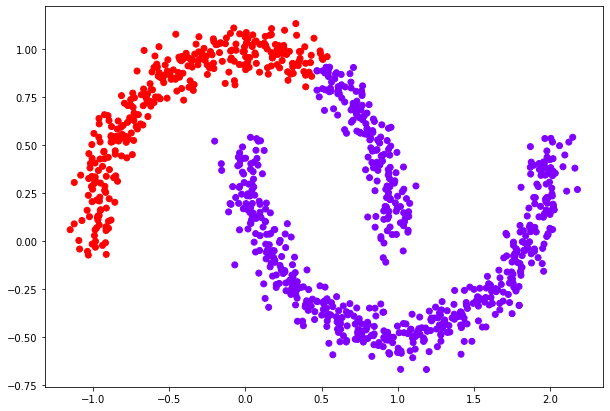

In [79]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong><br>

prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [80]:
X, y = X_circles, y_circles

In [81]:
linked = linkage(X, 'single')

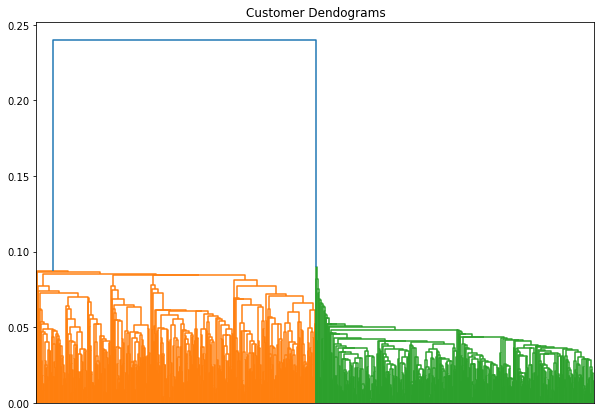

In [82]:
print_dendogram(linked)

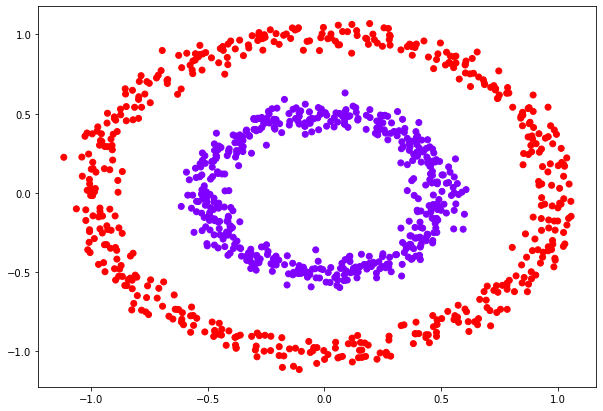

In [83]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='single')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [84]:
linked = linkage(X, 'complete')

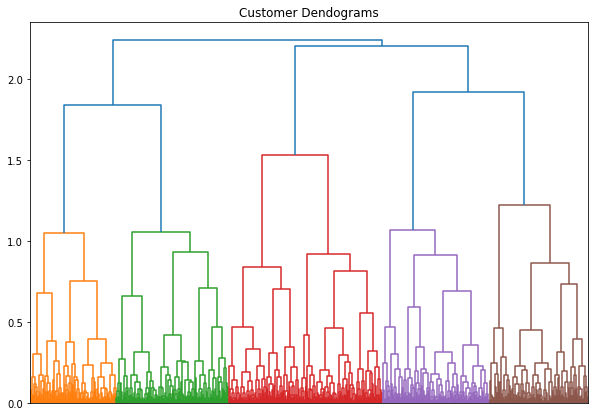

In [85]:
print_dendogram(linked)

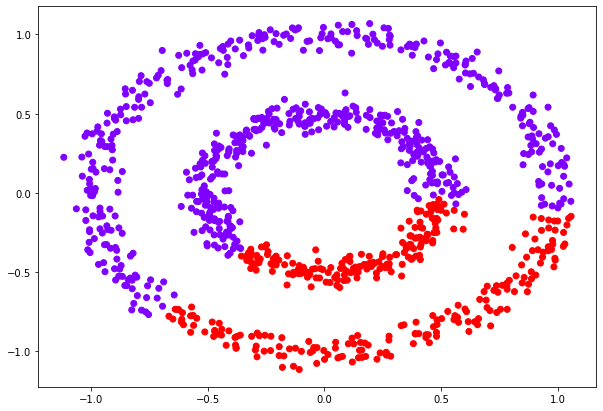

In [86]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='complete')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [87]:
linked = linkage(X, 'average')

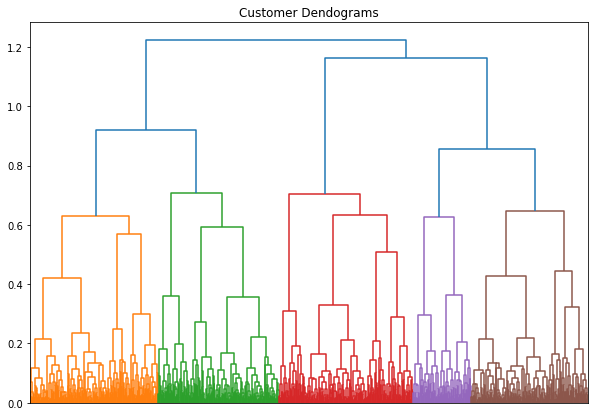

In [88]:
print_dendogram(linked)

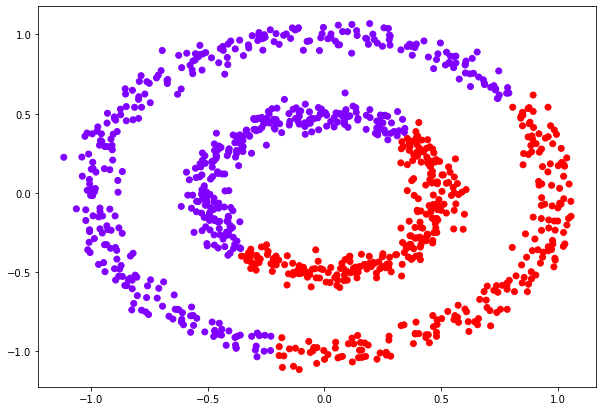

In [89]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='average')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [90]:
linked = linkage(X, 'ward')

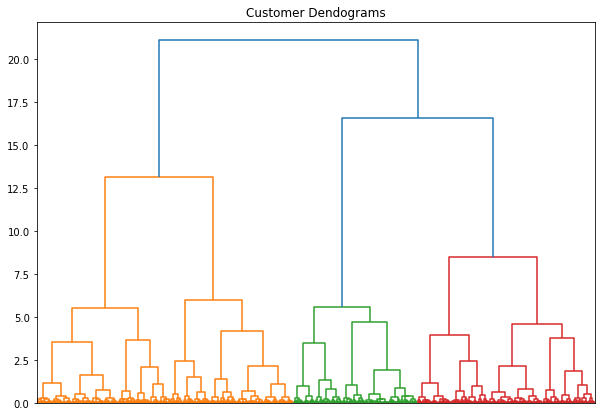

In [91]:
print_dendogram(linked)

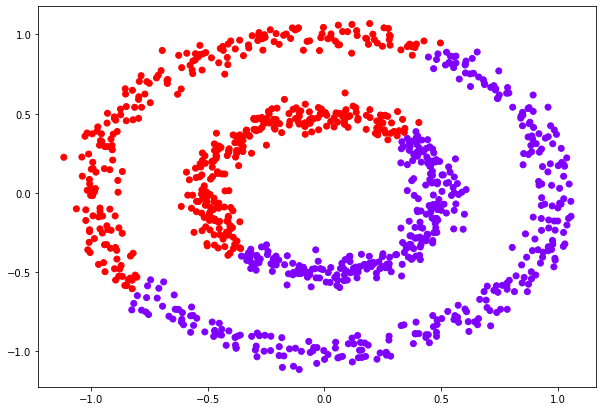

In [92]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

## 2. Aplicación de reducción de dimensionalidad (2 puntos)

Es posible aplicar una amplia variedad de algoritmos para la reducción de dimensionalidad. Para ello se empleará el dataset MNIST compuesto de miles de dígitos manuscritos del 0 al 9. Donde cada imagen se compone de 784 píxeles (imágenes de 28 x 28), por lo que se parte de un número alto de dimensiones.

In [93]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=5000, test_size=5000)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

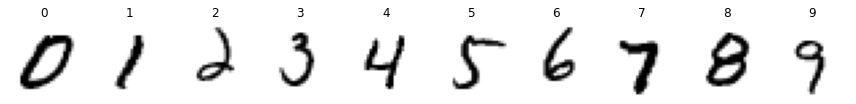

In [94]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in zip(range(10), axis):
    ax.imshow(X_train[y_train == i][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

In [95]:
X_train.shape # 5000 muestras con 784 valores (pixeles)

(5000, 784)

Si cada algoritmo obtiene resultados distintos a la hora de reducir la dimensionalidad, ¿qué representación es más fiel a la distribución original?

Antes de reducir las 784 dimensiones originales de cada muestra a 2 para poder visualizarlas en 2 dimensiones, es muy útil conocer, o al menos intuir, la estructura en alta dimensionalidad de los datos.

Para ello se puede hacer uso del dendrograma como heurística para conocer la disposición original de los datos y comprobar si la proyección es similar a lo mostrado por el dendrograma.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> realiza un dendrograma con las muestras de X_train (o un subconjunto de ellas para acelerar el proceso) usando el método ward. <br>
    Como consejo, la función dendrogram tiene un parámetro llamado no_labels que evita mostrar etiquetas para cada muestra y puesto a True evita mostrarlas, cargando la imagen más rápido.
</div>

In [96]:
linked = linkage(X_train, 'ward')

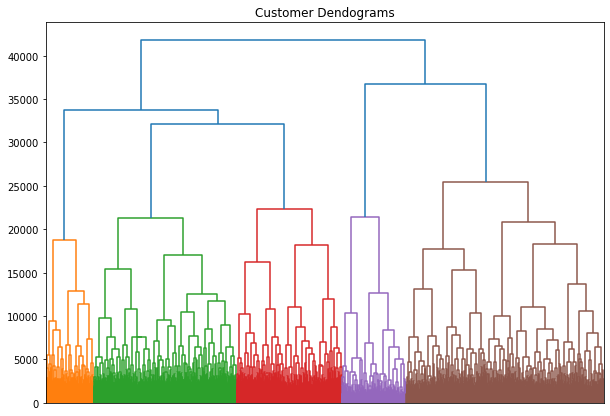

In [97]:
print_dendogram(linked)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X_train con PCA y proyectar el conjunto X_test a dos dimensiones. Después visualizarlo en un scatter plot.<br>
    Puedes utilizar las etiquetas de y_test, el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad.
</div>

In [98]:
from sklearn.decomposition import PCA


In [99]:
import seaborn as sns

In [100]:
pca = PCA(n_components=2)
mnist_pca = pca.fit(X_train)

In [101]:
X_test_pca = mnist_pca.transform(X_test)

In [102]:
X_test_pca

array([[-134.18080005,  734.75527211],
       [ 458.39320339,  164.03909954],
       [-332.97010493, -457.96003637],
       ...,
       [-909.38455068, -235.3710033 ],
       [-798.94926431,  349.39399687],
       [ 786.54527401,  225.74630467]])

In [103]:
X_test_pca = pd.DataFrame(data = X_test_pca, columns=['independent_feature_1', 'independent_feature_2'])
X_test_pca['class'] = y_test

<AxesSubplot:xlabel='independent_feature_1', ylabel='independent_feature_2'>

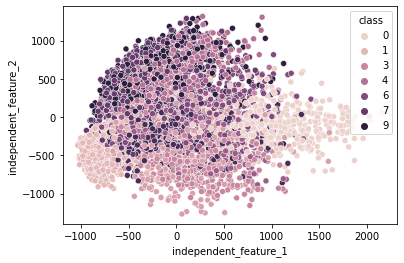

In [104]:
sns.scatterplot(data=X_test_pca, x="independent_feature_1", y="independent_feature_2", hue="class")


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se puede intuir de la proyección? ¿Se parece a lo representado en el dendrograma?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X_train con UMAP y proyectar el conjunto X_test a dos dimensiones. Después visualizarlo en un scatter plot.<br>
    Puedes utilizar las etiquetas de y_test, el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad.
</div>

In [105]:
mnist_umap = umap.UMAP().fit(X_train)

In [106]:
X_test_umap = mnist_umap.transform(X_test)

In [107]:
X_test_umap

array([[ 9.743333  ,  5.0886135 ],
       [ 3.0305793 ,  0.36111856],
       [ 5.6300793 ,  0.99060154],
       ...,
       [ 8.593094  , -0.01110702],
       [ 7.736042  ,  4.8066597 ],
       [-0.09441466,  3.2223985 ]], dtype=float32)

In [108]:
X_test_umap = pd.DataFrame(data = X_test_umap, columns=['independent_feature_1', 'independent_feature_2'])
X_test_umap['class'] = y_test

<AxesSubplot:xlabel='independent_feature_1', ylabel='independent_feature_2'>

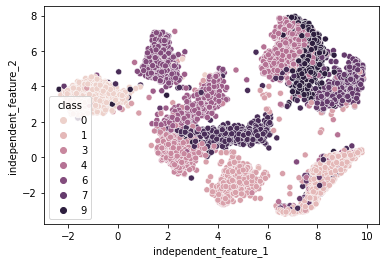

In [109]:
sns.scatterplot(data=X_test_umap, x="independent_feature_1", y="independent_feature_2", hue="class")


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se puede intuir de la proyección? ¿Se parece a lo representado en el dendrograma?
</div>

## 3. Aplicación: segmentación de imágenes de satélite (4 puntos)

Hoy en día los mapas de carreteras, geológicos, agrícolas... se confeccionan con imágenes satélites. Para ello es necesario interpretar esas imágenes buscando en ellas los elementos de interés. Dado el volumen actual de imágenes que generan los satélites, hacer la segmentación de forma manual no es una opción y por ello hay tantos esfuerzos en su automatización.

Asumiendo que el espacio de píxeles tiene cierta estructura y que los distintos elementos a buscar son grupos en ella. Es razonable pensar que una estrategia de clustering (entre muchas otras) puede hallar estos grupos en dicha estructura, permitiendo automatizar la segmentación de imágenes.

Partimos de una imagen con diversos tipos de vegetación y caminos:

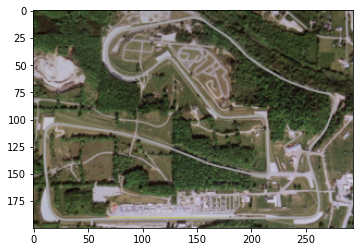

In [422]:
from skimage import io, transform

photo = transform.resize(
    io.imread('https://lh3.googleusercontent.com/-kHq0XyQh3b8/TYFk1h0r2-I/AAAAAAAAAJA/i3rdSELDqxM/s1600/road_america_base.jpg'),
    (200, 294), mode='edge')
plt.imshow(photo)
X = photo.reshape(-1, 3)

Al igual que en el apartado anterior, se ha dado un formato de array a la imagen con tantas filas como píxeles y 3 columnas (una por canal).

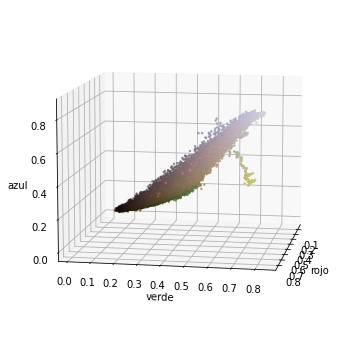

In [112]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pixels_3d(data: "np.array[float]", elev: int = None, azim: int = None) -> None:
    """Visualiza pixeles en un scatter plot 3d (una por canal) con su color correspondiente.
    
    Args:
        data: np.array (puntos, 3)
        elev: int
            angulo de eleveacion en el plano z.
        azim: int
            angulo acimut en el plano x, y.
    """
    assert data.shape[1] == 3, 'Se esperaba un array bidimensional con 3 columnas: (rojo, verde y azul)'
    ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s=2, c=data)
    ax.set_xlabel('rojo')
    ax.set_ylabel('verde')
    ax.set_zlabel('azul')
    ax.view_init(elev, azim)
    plt.show()

plot_pixels_3d(X, 10, 10)

En la visualización anterior se ha representado cada píxel con su color, donde sus coordenadas en los 3 colores oscilan entre 0 (carece de esa componente) y 1. Podemos comprobar como los píxeles en coordenadas (1, 1, 1) son píxeles blancos y los situados en (0, 0, 0) son píxeles negros.

Visualizando en 3 dimensiones los píxeles de la imagen vemos que en este caso no están tan diferenciados los grupos. Pero sí que los píxeles más claros pertenecen a la zona de caminos y los más oscuros al área de vegetación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aplica una técnica de clustering para separar los caminos de la vegetación y visualiza tanto la imagen original como la resultante tras aplicar la segmentación para comparar el resultado. ¿Qué algoritmo has elegido? ¿Por qué?
</div>

In [258]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [259]:
X_df = pd.DataFrame(X)
X_df['cluster'] = y_kmeans

In [184]:
def plot_cluster_3d(df,elev: int = None, azim: int = None):
    fig = plt.figure()
    ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
    for c in df.cluster.unique():
        ax.scatter(df[df['cluster']==c][0],df[df['cluster']==c][1],df[df['cluster']==c][2],s=2,label=c)
    ax.set_xlabel('rojo')
    ax.set_ylabel('verde')
    ax.set_zlabel('azul')
    ax.legend()
    ax.view_init(elev, azim)

<Figure size 432x288 with 0 Axes>

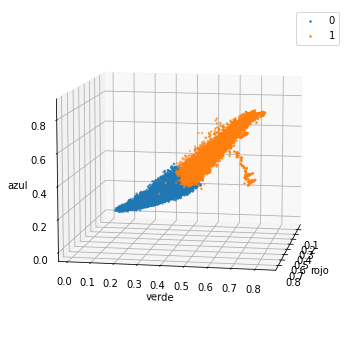

In [260]:
plot_cluster_3d(X_df, 10, 10)

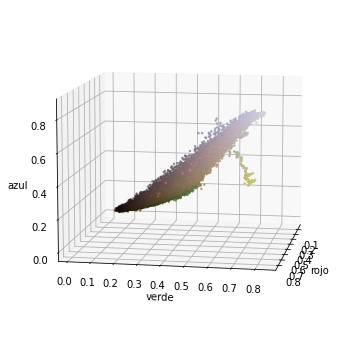

In [261]:
plot_pixels_3d(X, 10, 10)

In [262]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
img_segm = centroids[labels]
img_segm = img_segm.reshape(photo.shape)

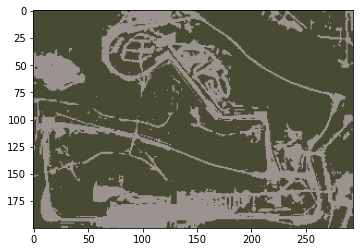

In [263]:
plt.imshow(img_segm)


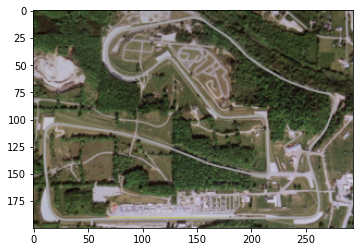

In [264]:
plt.imshow(photo)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> vuelve a aplicarlo buscando 3 grupos de píxeles.
</div>

In [231]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [232]:
X_df = pd.DataFrame(X)
X_df['cluster'] = y_kmeans

<Figure size 432x288 with 0 Axes>

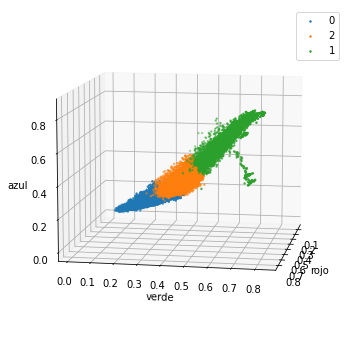

In [233]:
plot_cluster_3d(X_df, 10, 10)

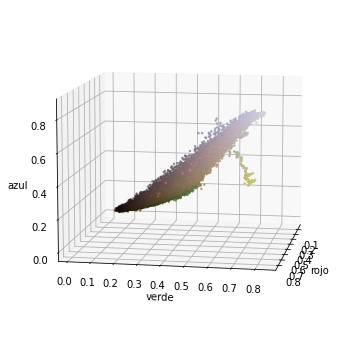

In [234]:
plot_pixels_3d(X, 10, 10)

In [254]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
img_segm = centroids[labels]
img_segm = img_segm.reshape(photo.shape)

In [268]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [267]:
 centroids[labels]

array([[0.28363502, 0.29518725, 0.20242426],
       [0.28363502, 0.29518725, 0.20242426],
       [0.28363502, 0.29518725, 0.20242426],
       ...,
       [0.28363502, 0.29518725, 0.20242426],
       [0.28363502, 0.29518725, 0.20242426],
       [0.28363502, 0.29518725, 0.20242426]])

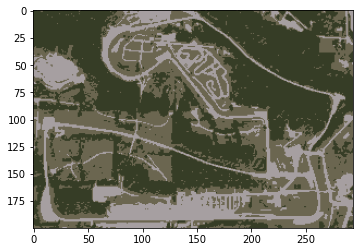

In [256]:
plt.imshow(img_segm)


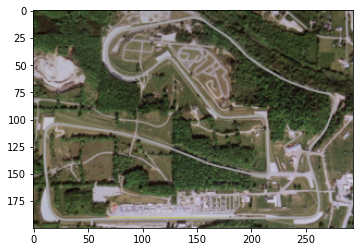

In [257]:
plt.imshow(photo)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué region representa cada uno de ellos?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> el último paso consiste en aplicar el clustering y separar los caminos del fondo, poniendo este último en negro (rellenar con 0 los valores de los píxeles del fondo). Quedando segmentandos de manera automática los caminos del resto de elementos de la fotografía.
</div>

In [409]:
from more_itertools import zip_equal as izip


In [423]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [424]:
y_kmeans

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [440]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
img_segm = centroids[labels]
img_segm = img_segm.reshape(photo.shape)

In [465]:
X_df = pd.DataFrame(X)
X_df['cluster'] = y_kmeans

In [466]:
X_df['cluster'].value_counts()

0    41323
1    17477
Name: cluster, dtype: int64

In [467]:
def function(row):
    if row.cluster == 0:
        return 0,0,0
    else:
        return 198,183,172

In [468]:
X_df[0], X_df[1], X_df[2] = izip(*X_df.apply(lambda func: function(func), axis=1))

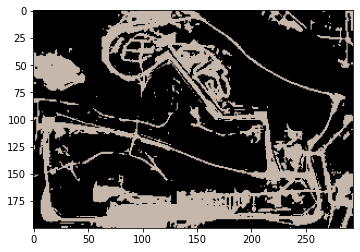

In [469]:
plt.imshow(X_df[[0,1,2]].to_numpy().reshape(photo.shape))
